In [5]:
!pip install gym

We import the libraries, create our own 6x6 environment. S denotes the starting point. F - ice is safe (frozen), H - hole, G - goal. The parameter is_slippery = False is responsible for slipping. That is, if the agent chose the action to go right, then it will move to the corresponding state. In the general case, due to the “slipping”, one may find itself in a different state. We also copied from the GYM library and slightly modified the function generate_random_map, in order to generate arbitrary maps based on random_seed.

In [30]:
gamma = 0.9 # Discount coefficient gamma
random_seed = 5 #Random seed
epsilon = 0.1
time_delay = 1 # Time delay when rendering the game process after training (seconds)
lr_rate = 0.9 #Learning rate alpha

In [31]:
import gym
import numpy as np
import time
from IPython.display import clear_output


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

# Map generation
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) #Create our map
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #Initialize environment
print("Your map")
env.render() #Render the map

Your map

SHFHFF
FFFFFF
FFHFFF
FFFFFF
FFFHHF
FFFFFG


In [32]:
#Q.shape
epsilon

0.1

In [33]:
from tqdm import tqdm #progress bar
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, action2, done):
    if done:
          Q[state, action] = Q[state, action] + lr_rate * (reward - Q[state, action])
    else:
          Q[state, action] = Q[state, action] + lr_rate * (reward + gamma * Q[state2, action2] - Q[state, action])

In [34]:
# Inititalization
np.random.seed(random_seed)
total_games = 40000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))
wins_arr = []
min_game = 0

for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    action = choose_action(state) #Choice of action at the very beginning of each game
    while t < max_steps:
        if np.sum(wins_arr[-5:]) == 5 and min_game == 0:
            min_game = game
        t += 1
        state2, reward, done, info = env.step(action)
        action2 = choose_action(state2) #choice of action for the next step of the game, as well as for updating the value of the current action
        if t == max_steps:
            done = True  
        learn(state, state2, reward, action, action2, done) # action2 is also passed to the training function
        state = state2
        action = action2

        if done and reward == 1:
            wins_arr.append(1)
            break
        if done:
            wins_arr.append(0)
            break

"""#Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    while t < max_steps:
        if np.sum(wins_arr[-5:]) == 5 and min_game == 0:
            min_game = game
        t += 1
        action = choose_action(state)
        state2, reward, done, info = env.step(action)
        if t == max_steps:
              done = True  
        learn(state, state2, reward, action, done)
        state = state2
        
        if done and reward == 1:
            wins_arr.append(1)
            break
        if done:
            wins_arr.append(0)
            break"""
print("Первые 5 побед\t", min_game)
print("Всего побед\t", np.sum(wins_arr))

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [01:46<00:00, 374.83it/s]

Первые 5 побед	 757
Всего побед	 30615


In [35]:
import time
#Greedy action selection
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[]#Array to save agent states during the game
t = 0
state = env.reset()
wn = 0
while(t<100):
    env.render()
    time.sleep(time_delay)
    clear_output(wait=True)
    action = choose_action_one_game(state)  
    state2, reward, done, info = env.step(action)  
    states.append(state)
    state = state2
    t += 1
    if done and reward == 1:
        wn=1
    if done:
        break
    if wn == 1:
      print("!!!WIN!!!")

  (Right)
SHFHFF
FFFFFF
FFHFFF
FFFFFF
FFFHHF
FFFFFG


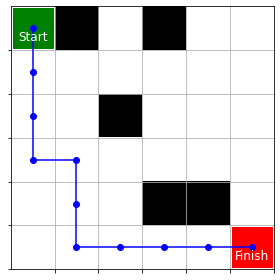

In [36]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
    maze_pic=[]
    for i in range(len(maze)):
        row = []
        for j in range(len(maze[i])):
            if maze[i][j] == 'S':
                row.append(0)
            if maze[i][j] == 'F':
                row.append(0)
            if maze[i][j] == 'H':
                row.append(1)
            if maze[i][j] == 'G':
                row.append(0)
        maze_pic.append(row)
    maze_pic = np.array(maze_pic)
    return maze_pic
  

#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
    rw = np.append(rw, [nrows-1])
    cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")

# SARSA